Mounted at /content/drive
Dataset folders: ['val', 'train', 'test', 'label_colors.txt']
Train: 811 images
Val: 203 images
Test: 254 images


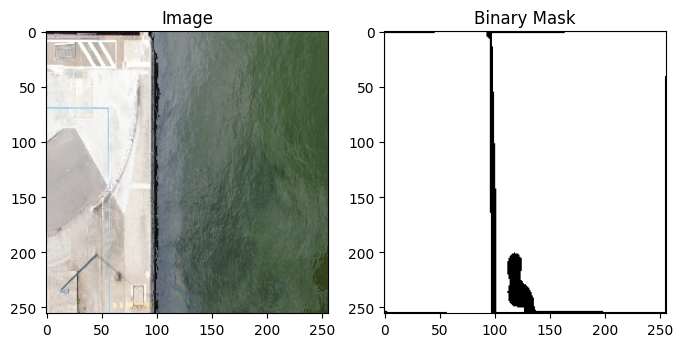

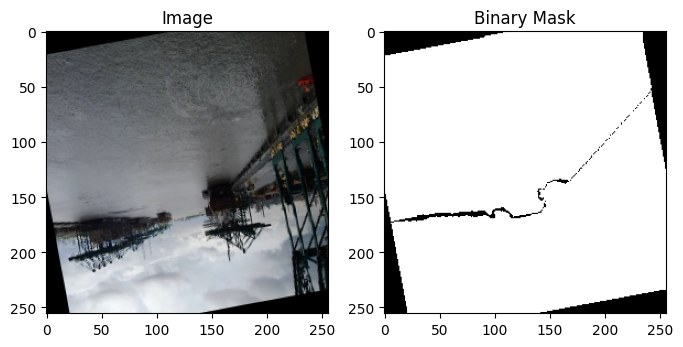

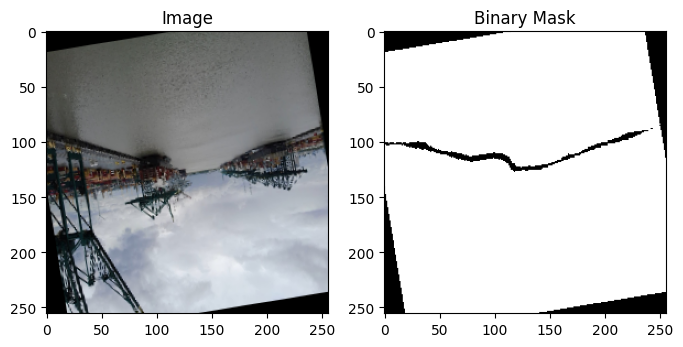

 Dataset loaded, preprocessed & augmented successfully.


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from glob import glob
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
from torch.utils.data import Dataset, DataLoader

# mount google drive (only once for dataset loading)
from google.colab import drive
drive.mount('/content/drive')

DATASET_PATH = "/content/drive/MyDrive/infosys/oil_spill_dataset"

print("Dataset folders:", os.listdir(DATASET_PATH))


# utility functions: preprocessing of raw data
def load_image(path):
    """Load image in RGB"""
    return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)

def load_mask(path):
    """Load mask and convert RGB -> binary (spill vs non-spill)"""
    mask = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY) # convert to grayscale
    _, binary = cv2.threshold(gray, 127, 1, cv2.THRESH_BINARY)     # binary threshold (0 = non-spill(backgrouund), 1 = spill)
    return binary


# custom dataset class
class OilSpillDataset(Dataset):
    def __init__(self, images, masks, transform=None):
        self.images = images
        self.masks = masks
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = load_image(self.images[idx])
        mask = load_mask(self.masks[idx])

        if self.transform:
            aug = self.transform(image=image, mask=mask)
            image, mask = aug['image'], aug['mask']

        return image, mask.long()
# augmentation+ preprocessing



# data paths
train_images = sorted(glob(os.path.join(DATASET_PATH, "train/images/*")))
train_masks  = sorted(glob(os.path.join(DATASET_PATH, "train/masks/*")))
val_images   = sorted(glob(os.path.join(DATASET_PATH, "val/images/*")))
val_masks    = sorted(glob(os.path.join(DATASET_PATH, "val/masks/*")))
test_images  = sorted(glob(os.path.join(DATASET_PATH, "test/images/*")))
test_masks   = sorted(glob(os.path.join(DATASET_PATH, "test/masks/*")))

print(f"Train: {len(train_images)} images")
print(f"Val: {len(val_images)} images")
print(f"Test: {len(test_images)} images")


# transformations +augmentation
# basic preprocessing (resize + normalize)
basic_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)),
    ToTensorV2()
])

# augmentation (to balance classes if imbalanced)
augment_transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=30, p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)),
    ToTensorV2()
])


# datasets & loaders
train_dataset = OilSpillDataset(train_images, train_masks, transform=augment_transform)
val_dataset   = OilSpillDataset(val_images, val_masks, transform=basic_transform)

train_loader  = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader    = DataLoader(val_dataset, batch_size=8, shuffle=False)
# this was whole data input pipeline for model training



# visualization pipeline
def denormalize(image):
    """Convert from [-1,1] back to [0,1] for display"""
    image = (image * 0.5) + 0.5
    return np.clip(image, 0, 1)

def visualize_sample(dataset, n=3):
    for i in range(n):
        image, mask = dataset[i]
        image = image.permute(1,2,0).numpy()  # CHW -> HWC
        image = denormalize(image)             # fix warnings
        mask = mask.numpy()

        fig, ax = plt.subplots(1, 2, figsize=(8,4))
        ax[0].imshow(image)
        ax[0].set_title("Image")
        ax[1].imshow(mask, cmap='gray')
        ax[1].set_title("Binary Mask")
        plt.show()

visualize_sample(train_dataset, n=3)

print(" Dataset loaded, preprocessed & augmented successfully.")


Data Input & Preprocessing Pipeline:

- Mounted Google Drive and set dataset path.

- Defined utility functions to load images and masks (converted RGB masks into binary segmentation masks).

- Built a custom PyTorch Dataset class OilSpillDataset to handle paired image-mask loading with optional augmentations.

- Created separate train, validation, and test sets by loading paths and applying Albumentations transformations:

Basic Transform → Resize + Normalize

Augment Transform → Resize, Flips, Rotations, Brightness/Contrast, Normalize

- Initialized PyTorch DataLoaders for batching and shuffling.

- Added visualization utilities (visualize_sample) to check if preprocessing and augmentations are applied correctly.
- At this stage, we ensured dataset is structured, normalized, and ready for training.

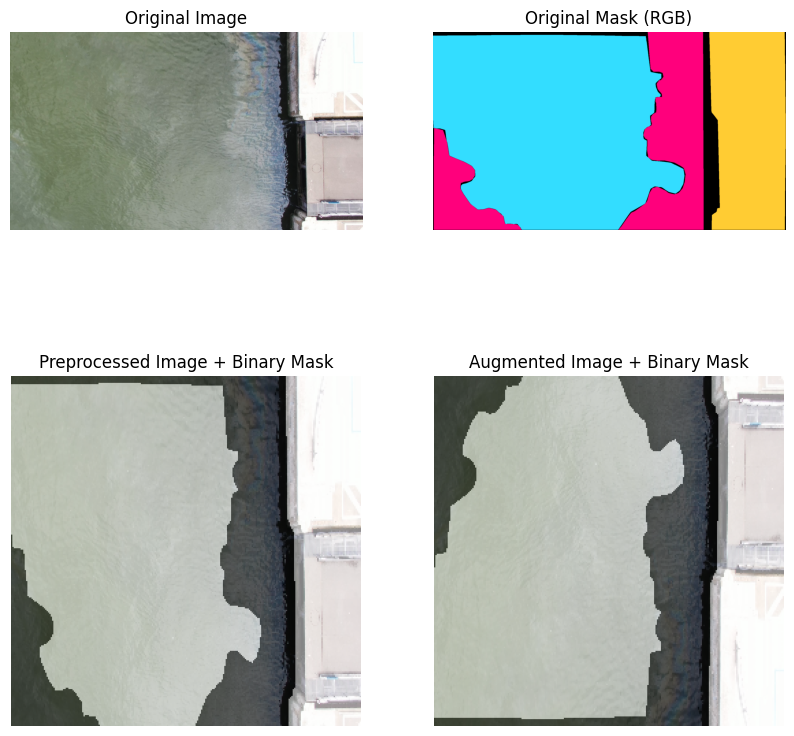

In [2]:
def visualize_pipeline(img_path, mask_path):
    # Original
    orig_img = load_image(img_path)
    orig_mask = cv2.cvtColor(cv2.imread(mask_path), cv2.COLOR_BGR2RGB)

    # binary preprocessed (basic_transform, no aug)
    preproc = basic_transform(image=orig_img, mask=load_mask(mask_path))
    pre_img, pre_mask = preproc['image'], preproc['mask']
    pre_img = pre_img.permute(1,2,0).numpy()
    pre_img = (pre_img * 0.5) + 0.5  # denormalize for display
    pre_mask = pre_mask.numpy()

    # augmented
    aug = augment_transform(image=orig_img, mask=load_mask(mask_path))
    aug_img, aug_mask = aug['image'], aug['mask']
    aug_img = aug_img.permute(1,2,0).numpy()
    aug_img = (aug_img * 0.5) + 0.5  # denormalize
    aug_mask = aug_mask.numpy()

    # plot
    fig, ax = plt.subplots(2, 2, figsize=(10,10))

    ax[0,0].imshow(orig_img)
    ax[0,0].set_title("Original Image"); ax[0,0].axis("off")

    ax[0,1].imshow(orig_mask)
    ax[0,1].set_title("Original Mask (RGB)"); ax[0,1].axis("off")

    ax[1,0].imshow(pre_img)
    ax[1,0].imshow(pre_mask, cmap='gray', alpha=0.5)  # overlay mask
    ax[1,0].set_title("Preprocessed Image + Binary Mask"); ax[1,0].axis("off")

    ax[1,1].imshow(aug_img)
    ax[1,1].imshow(aug_mask, cmap='gray', alpha=0.5)
    ax[1,1].set_title("Augmented Image + Binary Mask"); ax[1,1].axis("off")

    plt.show()

visualize_pipeline(train_images[5], train_masks[5])


Visualization Pipeline for Preprocessing & Augmentation:

  - Compared Original image & mask with their preprocessed and augmented versions.

  - Preprocessing: Resized and normalized the image, converted mask into binary form, and overlaid mask on the image.

  - Augmentation: Applied random flips, rotations, and brightness/contrast changes to generate diverse training examples.

  - Displayed results in a 2x2 grid → Original vs Preprocessed vs Augmented, making it easy to visually verify correctness.
  - This confirms that input images and masks are properly aligned, and augmentations maintain semantic correctness.

MILESTONE 1 COMPLETED!

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 8.2 MB/s eta 0:00:00
Using device: cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]


 Epoch 1/20


 Train Loss: 0.6699 | Val Loss: 0.4128 | Val Acc: 0.9179
 Best model saved!

 Epoch 2/20


 Train Loss: 0.4426 | Val Loss: 0.3584 | Val Acc: 0.9304
 Best model saved!

 Epoch 3/20


 Train Loss: 0.3555 | Val Loss: 0.3976 | Val Acc: 0.8986

 Epoch 4/20


 Train Loss: 0.3093 | Val Loss: 0.2727 | Val Acc: 0.9330
 Best model saved!

 Epoch 5/20


 Train Loss: 0.3173 | Val Loss: 0.2309 | Val Acc: 0.9471
 Best model saved!

 Epoch 6/20


 Train Loss: 0.2787 | Val Loss: 0.2036 | Val Acc: 0.9551
 Best model saved!

 Epoch 7/20


 Train Loss: 0.2644 | Val Loss: 0.2001 | Val Acc: 0.9553
 Best model saved!

 Epoch 8/20


 Train Loss: 0.2360 | Val Loss: 0.1832 | Val Acc: 0.9604
 Best model saved!

 Epoch 9/20


 Train Loss: 0.2109 | Val Loss: 0.1769 | Val Acc: 0.9589
 Best model saved!

 Epoch 10/20


 Train Loss: 0.1950 | Val Loss: 0.2028 | Val Acc: 0.9527

 Epoch 11/20


 Train Loss: 0.1968 | Val Loss: 0.1558 | Val Acc: 0.9660
 Best model saved!

 Epoch 12/20


 Train Loss: 0.1942 | Val Loss: 0.1493 | Val Acc: 0.9637
 Best model saved!

 Epoch 13/20


 Train Loss: 0.2256 | Val Loss: 0.1893 | Val Acc: 0.9596

 Epoch 14/20


 Train Loss: 0.2092 | Val Loss: 0.1631 | Val Acc: 0.9651

 Epoch 15/20


 Train Loss: 0.1907 | Val Loss: 0.1555 | Val Acc: 0.9673

 Epoch 16/20


 Train Loss: 0.1947 | Val Loss: 0.1476 | Val Acc: 0.9671
 Best model saved!

 Epoch 17/20


 Train Loss: 0.1874 | Val Loss: 0.1508 | Val Acc: 0.9636

 Epoch 18/20


 Train Loss: 0.1762 | Val Loss: 0.1346 | Val Acc: 0.9701
 Best model saved!

 Epoch 19/20


 Train Loss: 0.1478 | Val Loss: 0.1199 | Val Acc: 0.9725
 Best model saved!

 Epoch 20/20


 Train Loss: 0.1446 | Val Loss: 0.1219 | Val Acc: 0.9712

 Training finished!


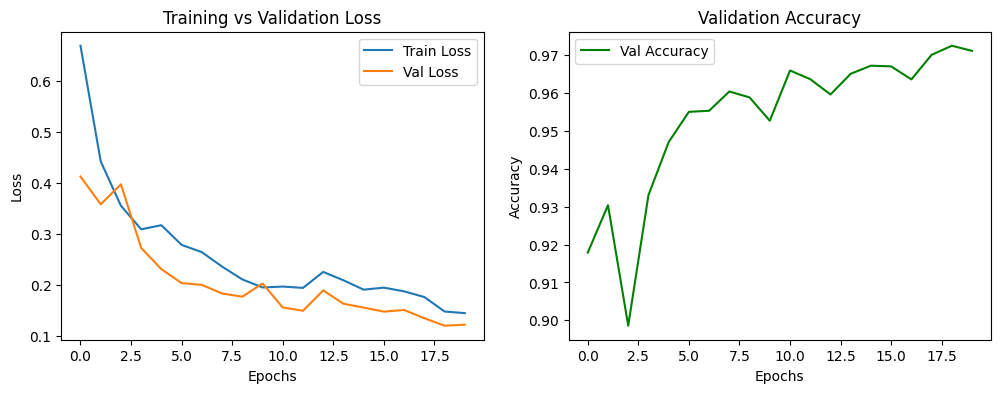

In [3]:
# model training
!pip install segmentation-models-pytorch --quiet

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import segmentation_models_pytorch as smp
from tqdm import tqdm
import matplotlib.pyplot as plt

# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


# model (U-Net with ResNet34 encoder)
model = smp.Unet(
    encoder_name="resnet34",      # backbone
    encoder_weights="imagenet",   # pretrained weights
    in_channels=3,                # RGB images
    classes=1                     # binary segmentation
).to(device)


# loss and optimizer
dice_loss = smp.losses.DiceLoss(mode="binary")
bce_loss  = nn.BCEWithLogitsLoss()

def combined_loss(y_pred, y_true):
    return dice_loss(y_pred, y_true) + bce_loss(y_pred, y_true)

optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=3
)

# data loaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2)

# metrics
def pixel_accuracy(outputs, masks):
    preds = (torch.sigmoid(outputs) > 0.5).float()
    correct = (preds == masks).float().sum()
    total = torch.numel(masks)
    return correct / total


# training and validation loops
def train_one_epoch(model, loader, optimizer):
    model.train()
    epoch_loss = 0
    for imgs, masks in tqdm(loader, desc="Training", leave=False):
        imgs, masks = imgs.to(device), masks.to(device).unsqueeze(1).float()

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = combined_loss(outputs, masks)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    return epoch_loss / len(loader)


def validate_one_epoch(model, loader):
    model.eval()
    epoch_loss = 0
    epoch_acc = 0
    with torch.no_grad():
        for imgs, masks in tqdm(loader, desc="Validation", leave=False):
            imgs, masks = imgs.to(device), masks.to(device).unsqueeze(1).float()
            outputs = model(imgs)

            loss = combined_loss(outputs, masks)
            acc  = pixel_accuracy(outputs, masks)

            epoch_loss += loss.item()
            epoch_acc  += acc.item()

    return epoch_loss / len(loader), epoch_acc / len(loader)


# training loop
num_epochs = 20
train_losses, val_losses, val_accuracies = [], [], []
best_val_loss = float("inf")

for epoch in range(num_epochs):
    print(f"\n Epoch {epoch+1}/{num_epochs}")

    train_loss = train_one_epoch(model, train_loader, optimizer)
    val_loss, val_acc = validate_one_epoch(model, val_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    scheduler.step(val_loss)

    print(f" Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model.pth")
        print(" Best model saved!")

print("\n Training finished!")

# plots
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epochs"); plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(val_accuracies, label="Val Accuracy", color="green")
plt.xlabel("Epochs"); plt.ylabel("Accuracy")
plt.title("Validation Accuracy")
plt.legend()

plt.show()


1. Pretrained Encoder (ResNet34 on ImageNet)  
   - The U-Net uses ResNet34 pretrained on ImageNet as the encoder.  
   - This gives the model strong feature extraction ability from the start, instead of learning from scratch.

2. Binary Segmentation Task  
   - Since the problem is object vs. background (2 classes), it is easier to achieve high pixel-level accuracy.  

3. Pixel Accuracy Metric  
   - Pixel accuracy counts all pixels.  
   - If the dataset has more background pixels than object pixels, the model can appear very accurate even with partial learning.  

4. Combined Loss Function (BCE + Dice)  
   - BCE ensures stable optimization.  
   - Dice focuses directly on overlap between predictions and ground truth.  
   - This combination accelerates convergence.

5. Clean Dataset  
   - Well-prepared masks with clear object boundaries reduce noise and help the model perform better quickly.

That's why the model shows high accuracy from the very first epoch.

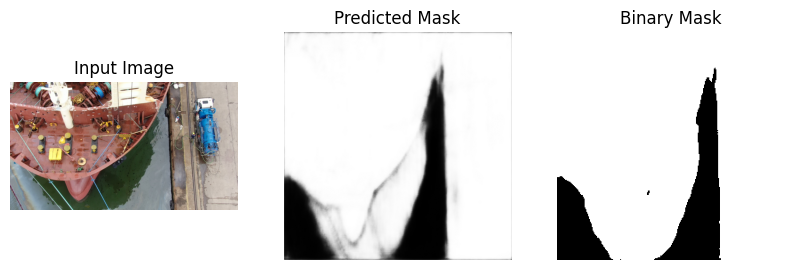

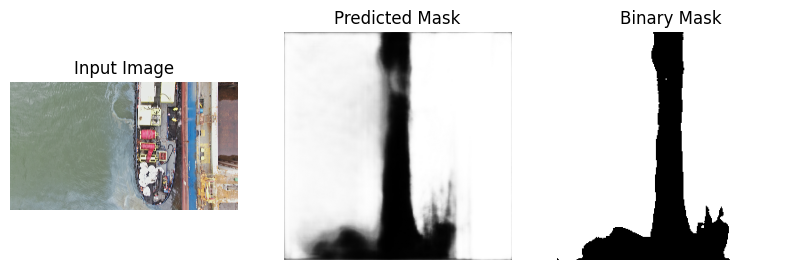

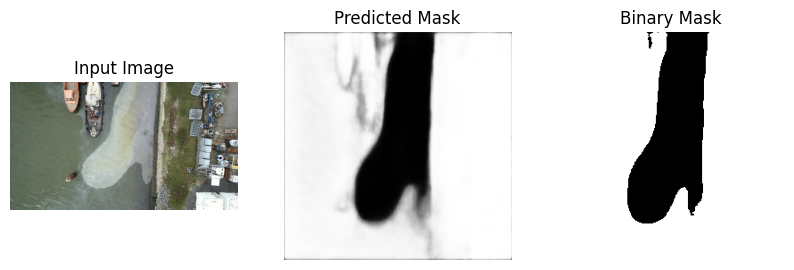

In [4]:
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image

# load model
model.load_state_dict(torch.load("best_model.pth", map_location=device))
model.eval()

# preprocessing (same as training)
transform = transforms.Compose([
    transforms.Resize((256, 256)),   # resize to training size
    transforms.ToTensor()
])

def predict_image(img_path):
    # Load image
    img = Image.open(img_path).convert("RGB")
    inp = transform(img).unsqueeze(0).to(device)  # [1, 3, H, W]

    # Predict
    with torch.no_grad():
        out = model(inp)
        pred_mask = torch.sigmoid(out).squeeze().cpu().numpy()

    # Threshold at 0.5
    binary_mask = (pred_mask > 0.5).astype("float32")

    # plot
    plt.figure(figsize=(10,4))
    plt.subplot(1,3,1); plt.imshow(img); plt.title("Input Image"); plt.axis("off")
    plt.subplot(1,3,2); plt.imshow(pred_mask, cmap="gray"); plt.title("Predicted Mask"); plt.axis("off")
    plt.subplot(1,3,3); plt.imshow(binary_mask, cmap="gray"); plt.title("Binary Mask"); plt.axis("off")
    plt.show()

# test on dataset images
predict_image("/content/drive/MyDrive/infosys/oil_spill_dataset/train/images/Oil (1135).jpg")
predict_image("/content/drive/MyDrive/infosys/oil_spill_dataset/train/images/Oil (1170).jpg")
predict_image("/content/drive/MyDrive/infosys/oil_spill_dataset/train/images/Oil (1193).jpg")


Testing the Model on Sample Images

  - Mounted Google Drive to access dataset.

  - Selected spill images for prediction.

  - Verified predictions by visualizing the segmentation outputs.

In [5]:
# Improved Training Setup
from torchvision import transforms

# Data Augmentation (only for training dataset)
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
])

val_transforms = transforms.Compose([
    transforms.ToTensor(),
])

# Update optimizer with weight decay
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

# Adjusted Loss Function (Dice weighted more)
def combined_loss(y_pred, y_true):
    return 0.7 * dice_loss(y_pred, y_true) + 0.3 * bce_loss(y_pred, y_true)

# Early Stopping Helper
class EarlyStopping:
    def __init__(self, patience=5):
        self.patience = patience
        self.counter = 0
        self.best_loss = float("inf")
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

early_stopping = EarlyStopping(patience=5)

#  Improved Training Loop
num_epochs = 20
train_losses, val_losses, val_accs = [], [], []
best_val_acc = 0.0
def validate_one_epoch(model, loader, loss_fn):
    model.eval()
    epoch_loss = 0
    epoch_acc = 0
    with torch.no_grad():
        for imgs, masks in loader:
            imgs, masks = imgs.to(device), masks.to(device).unsqueeze(1).float()
            outputs = model(imgs)

            # Compute loss using the given loss function
            loss = loss_fn(outputs, masks)
            epoch_loss += loss.item()

            # Compute pixel accuracy
            preds = (torch.sigmoid(outputs) > 0.5).float()
            correct = (preds == masks).float().sum()
            total = torch.numel(masks)
            epoch_acc += (correct / total).item()

    avg_loss = epoch_loss / len(loader)
    avg_acc = epoch_acc / len(loader)
    return avg_loss, avg_acc


for epoch in range(num_epochs):
    print(f"\n Improved Epoch {epoch+1}/{num_epochs}")

    train_loss = train_one_epoch(model, train_loader, optimizer)
    val_loss, val_acc = validate_one_epoch(model, val_loader, combined_loss)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    scheduler.step(val_loss)

    print(f" Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model_improved.pth")
        print(" Improved best model saved!")

    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered!")
        break

print("\n Improved Training finished!")
print(f" Final Best Accuracy: {best_val_acc:.4f}")



 Improved Epoch 1/20


 Train Loss: 0.0731 | Val Loss: 0.0724 | Val Acc: 0.9611
 Improved best model saved!

 Improved Epoch 2/20


 Train Loss: 0.0830 | Val Loss: 0.0735 | Val Acc: 0.9658
 Improved best model saved!

 Improved Epoch 3/20


 Train Loss: 0.0655 | Val Loss: 0.0659 | Val Acc: 0.9659
 Improved best model saved!

 Improved Epoch 4/20


 Train Loss: 0.0678 | Val Loss: 0.0560 | Val Acc: 0.9713
 Improved best model saved!

 Improved Epoch 5/20


 Train Loss: 0.0630 | Val Loss: 0.0566 | Val Acc: 0.9694

 Improved Epoch 6/20


 Train Loss: 0.0695 | Val Loss: 0.0603 | Val Acc: 0.9672

 Improved Epoch 7/20


 Train Loss: 0.0639 | Val Loss: 0.0492 | Val Acc: 0.9722
 Improved best model saved!

 Improved Epoch 8/20


 Train Loss: 0.0577 | Val Loss: 0.0476 | Val Acc: 0.9733
 Improved best model saved!

 Improved Epoch 9/20


 Train Loss: 0.0576 | Val Loss: 0.0595 | Val Acc: 0.9661

 Improved Epoch 10/20


 Train Loss: 0.0597 | Val Loss: 0.0556 | Val Acc: 0.9696

 Improved Epoch 11/20


 Train Loss: 0.0579 | Val Loss: 0.0799 | Val Acc: 0.9558

 Improved Epoch 12/20


 Train Loss: 0.0679 | Val Loss: 0.0592 | Val Acc: 0.9692

 Improved Epoch 13/20


 Train Loss: 0.0623 | Val Loss: 0.0465 | Val Acc: 0.9739
 Improved best model saved!

 Improved Epoch 14/20


 Train Loss: 0.0718 | Val Loss: 0.0615 | Val Acc: 0.9690

 Improved Epoch 15/20


 Train Loss: 0.0583 | Val Loss: 0.0477 | Val Acc: 0.9731

 Improved Epoch 16/20


 Train Loss: 0.0573 | Val Loss: 0.0476 | Val Acc: 0.9741
 Improved best model saved!

 Improved Epoch 17/20


 Train Loss: 0.0543 | Val Loss: 0.0485 | Val Acc: 0.9733

 Improved Epoch 18/20


 Train Loss: 0.0511 | Val Loss: 0.0573 | Val Acc: 0.9670
Early stopping triggered!

 Improved Training finished!
 Final Best Accuracy: 0.9741


Improved Training Setup

1. Data Augmentation

Training images are randomly flipped, rotated, and color-jittered.

This prevents overfitting by making the model robust to variations in orientation, brightness, and contrast.

Validation images are kept clean (only converted to tensors) to ensure fair evaluation.


2. Optimizer with Weight Decay

Adam optimizer is used with a small weight decay (L2 regularization).

This penalizes overly large weights and helps reduce overfitting.

3. Combined Loss Function (Dice + BCE, weighted)

The loss combines 70% Dice Loss and 30% Binary Cross-Entropy Loss.

Dice focuses on segmentation overlap (region similarity).

BCE provides stable pixel-wise classification.

The weighting ensures overlap accuracy is prioritized while keeping optimization stable.

4. Early Stopping

Training automatically stops if validation loss doesn’t improve for 5 epochs.

Prevents unnecessary training and avoids overfitting.

5. Validation Function

For each validation step, it calculates both average loss and pixel-level accuracy.

This helps track not just how well the model minimizes loss but also how precise the segmentation is at pixel level.

6. Learning Rate Scheduler

ReduceLROnPlateau lowers the learning rate when validation loss plateaus.

This fine-tunes learning in later epochs for better convergence.

7. Model Checkpointing

The best model (highest validation accuracy) is saved as best_model_improved.pth.

Ensures you always keep the strongest model, even if later epochs degrade.

8. Overall Benefit

With augmentation, combined loss, early stopping, LR scheduling, and checkpointing, this setup builds a robust end-to-end training pipeline that reduces overfitting, improves generalization, and ensures reliable segmentation performance.

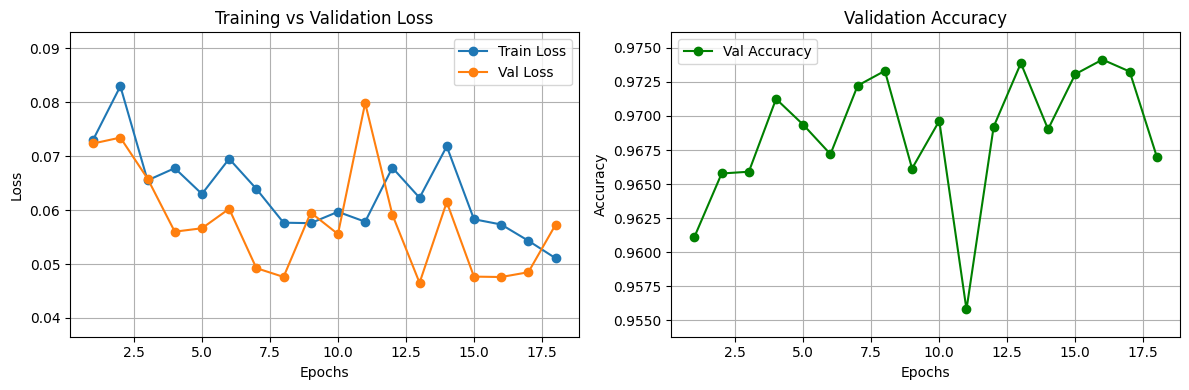

In [6]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12,4))

# ---------------- Loss curve ----------------
plt.subplot(1,2,1)
plt.plot(epochs, train_losses, label="Train Loss", marker="o")
plt.plot(epochs, val_losses, label="Val Loss", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)

# tighten the y-axis to zoom in
plt.ylim(min(min(train_losses), min(val_losses)) - 0.01,
         max(max(train_losses), max(val_losses)) + 0.01)

# ---------------- Accuracy curve ----------------
plt.subplot(1,2,2)
plt.plot(epochs, val_accs, label="Val Accuracy", color="green", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy")
plt.legend()
plt.grid(True)

# tighten the y-axis to zoom in (small range around your values)
plt.ylim(min(val_accs) - 0.002, max(val_accs) + 0.002)

plt.tight_layout()
plt.show()


Training & Validation Curves

Loss Curve: Shows how training and validation loss change over epochs. A decreasing loss with small gap indicates good learning and low overfitting.

Accuracy Curve: Tracks validation accuracy across epochs. A steady upward trend reflects improved segmentation quality.

Zoomed Y-axis: Tight limits highlight small improvements, making convergence patterns clearer.

👉 These plots help diagnose underfitting, overfitting, and model stability at a glance.

In [7]:
# Save model after training
torch.save(model.state_dict(), "unet_model.pth")

# Later / after restart, reload
model.load_state_dict(torch.load("unet_model.pth", map_location=device))
model.to(device)


Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

Validation Metrics: {'Dice': np.float64(0.9511659205090361), 'IoU': np.float64(0.9223408995944752), 'Precision': np.float64(0.896660242300585), 'Recall': np.float64(0.9047621609495512), 'F1-score': np.float64(0.8969787283819904)}


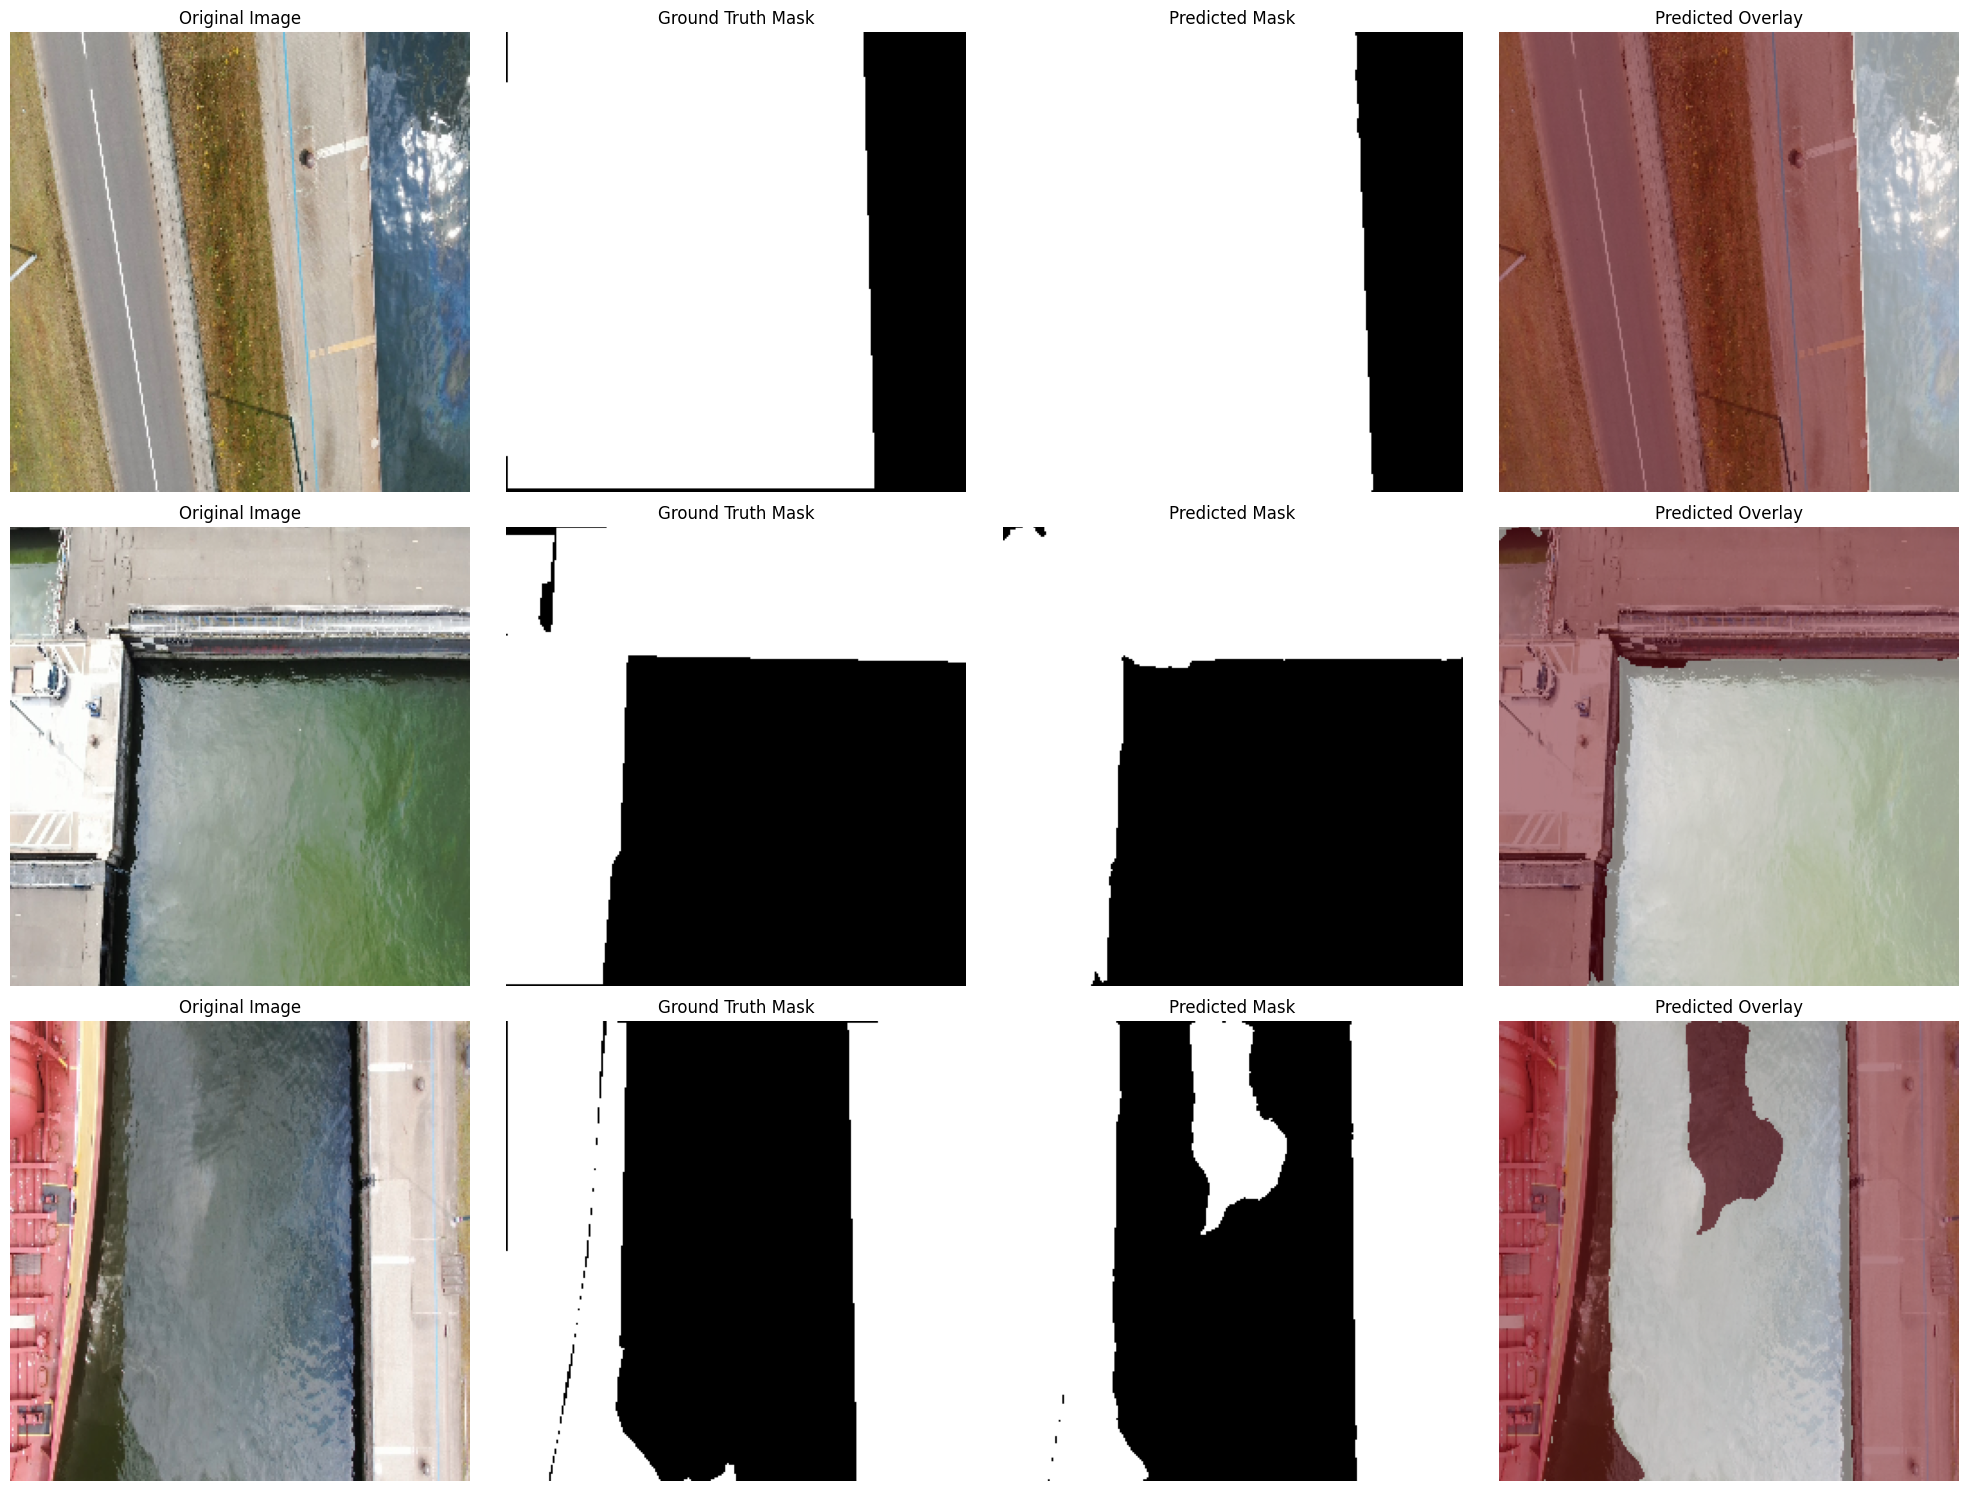

In [11]:
import torch
import torch.nn.functional as F
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt

# ---- Metric Functions ----
def dice_coef(y_true, y_pred, smooth=1e-7):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

def iou_score(y_true, y_pred, smooth=1e-7):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    union = np.sum(y_true_f) + np.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

def evaluate_model(model, dataloader, device):
    model.eval()
    dice_scores, iou_scores, precisions, recalls, f1s = [], [], [], [], []

    with torch.no_grad():
        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            preds = torch.sigmoid(outputs).cpu().numpy() > 0.5
            true = masks.cpu().numpy()

            for t, p in zip(true, preds):
                t, p = t.flatten(), p.flatten()
                dice_scores.append(dice_coef(t, p))
                iou_scores.append(iou_score(t, p))
                precisions.append(precision_score(t, p, zero_division=0))
                recalls.append(recall_score(t, p, zero_division=0))
                f1s.append(f1_score(t, p, zero_division=0))

    return {
        "Dice": np.mean(dice_scores),
        "IoU": np.mean(iou_scores),
        "Precision": np.mean(precisions),
        "Recall": np.mean(recalls),
        "F1-score": np.mean(f1s),
    }

# Example: Evaluate on validation dataset
metrics = evaluate_model(model, val_loader, device)
print("Validation Metrics:", metrics)


# ---- Enhanced Visualization (4 outputs) ----
import random

def visualize_predictions(model, dataset, device, num_samples=3):
    model.eval()
    indices = random.sample(range(len(dataset)), num_samples)

    plt.figure(figsize=(20, num_samples * 5))
    for i, idx in enumerate(indices):
        image, mask = dataset[idx]   # image: Tensor, mask: Tensor
        input_img = image.unsqueeze(0).to(device)

        with torch.no_grad():
            output = torch.sigmoid(model(input_img)).cpu().numpy()[0,0] > 0.5

        # Convert image tensor to numpy and rescale to [0,1]
        img_np = np.transpose(image.numpy(), (1,2,0))  # C,H,W -> H,W,C
        img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min() + 1e-7)

        # Ground truth mask: ensure shape (H,W)
        gt_mask = mask.squeeze().cpu().numpy()

        # Plot Original Image
        plt.subplot(num_samples, 4, i*4 + 1)
        plt.imshow(img_np, cmap='gray')
        plt.title("Original Image"); plt.axis('off')

        # Plot Ground Truth Mask
        plt.subplot(num_samples, 4, i*4 + 2)
        plt.imshow(gt_mask, cmap='gray')
        plt.title("Ground Truth Mask"); plt.axis('off')

        # Plot Predicted Mask
        plt.subplot(num_samples, 4, i*4 + 3)
        plt.imshow(output, cmap='gray')
        plt.title("Predicted Mask"); plt.axis('off')

        # Overlay Prediction on Image
        plt.subplot(num_samples, 4, i*4 + 4)
        plt.imshow(img_np, cmap='gray')
        plt.imshow(output, alpha=0.5, cmap='Reds')
        plt.title("Predicted Overlay"); plt.axis('off')

    plt.tight_layout()
    plt.show()

# Example visualization with 3 samples
visualize_predictions(model, val_dataset, device, num_samples=3)


Extended Evaluation & Visualization

1. Multiple Evaluation Metrics

Dice Coefficient: Measures overlap between predicted and ground-truth masks; very sensitive to segmentation quality.

IoU (Jaccard Index): Ratio of intersection to union between masks, a stricter version of overlap.

Precision: How many predicted pixels are actually correct (low false positives).

Recall: How many true pixels the model captures (low false negatives).

F1-score: Harmonic mean of Precision and Recall, balances both aspects.

Using multiple metrics ensures a complete picture of model performance beyond just accuracy.

2. Evaluation Function

Loops over the validation set.

Applies the trained model and thresholds predictions at 0.5.

Computes metrics per sample, averages results across dataset.

Provides a dictionary of scores (Dice, IoU, Precision, Recall, F1).

This gives a quantitative snapshot of segmentation quality.

3. Visualization Function
For qualitative analysis, each sample is displayed with 4 views side by side:

Original Image (input to the model).

Ground Truth Mask (the annotated oil spill region).

Predicted Mask (binary output of the model).

Overlay View (prediction layered on the original image in red).

Images are normalized for proper display.

Random samples are chosen for variety.

Overlays make it easy to see where the model matches or misses the spill boundaries.

4. Why This Matters

Metrics tell how well the model performs numerically.

Visualizations show where the model succeeds or fails in real examples.

Together, they provide both quantitative and qualitative validation of the segmentation pipeline.